In [99]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [100]:
CSV_PATH = "./data/bike_sharing_cleaned.csv"
baseDf = pd.read_csv(CSV_PATH)
baseDf

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,2011-01-01,1.0,0.0,1.0,0.0,0,6.0,0.0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2.0,2011-01-01,1.0,0.0,1.0,1.0,0,6.0,0.0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3.0,2011-01-01,1.0,0.0,1.0,2.0,0,6.0,0.0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4.0,2011-01-01,1.0,0.0,1.0,3.0,0,6.0,0.0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5.0,2011-01-01,1.0,0.0,1.0,4.0,0,6.0,0.0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17350,190355.0,2012-12-28,1.0,1.0,12.0,NaN,0,5.0,1.0,2,0.24,0.2424,0.55,0.1343,17,75,92
17351,11455.0,2012-04-27,2.0,1.0,4.0,23.0,0,5.0,1.0,1,0.44,0.4394,0.38,0.2836,47,186,233
17352,7465.0,2011-11-12,4.0,0.0,11.0,NaN,0,6.0,0.0,1,0.52,0.5000,0.29,0.2836,17,221,238
17353,11744.0,2012-05-09,2.0,1.0,5.0,NaN,0,2.0,1.0,2,0.62,0.6212,0.57,0.2985,58,222,280


In [101]:
df = baseDf[['dteday', 'cnt']]

df.columns = ['ds', 'y']

# Evitar problemas con duplicados
# Opción 1
df = df.drop_duplicates(subset="ds", keep="first")
df = df.dropna(subset=['ds'])

# Opción 2
# df = (
#     df.groupby("ds", as_index=False)
#       .agg({"cnt": "median"})
# )


df["ds"] = pd.to_datetime(df["ds"])
# Target
df["y"] = df["y"].astype(float)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 0 to 17293
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      731 non-null    datetime64[ns]
 1   y       731 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 17.1 KB


,ds,y
0,2011-01-01,16.0
24,2011-01-02,17.0
47,2011-01-03,5.0
69,2011-01-04,5.0
92,2011-01-05,6.0


In [102]:
# Config
TRAIN_END = "2012-06-30"
VAL_START, VAL_END = "2012-07-01", "2012-09-30"
TEST_START, TEST_END = "2012-10-01", "2012-12-31"
FREQ = "D"

In [103]:
df = df.sort_values("ds").set_index("ds").asfreq(FREQ)
df.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='ds', length=731, freq='D')

In [104]:
# Particionado
train      = df.loc[:TRAIN_END].copy()
validation = df.loc[VAL_START:VAL_END].copy()
test       = df.loc[TEST_START:TEST_END].copy()

print("Tamaños:")
print("train:", train.shape, "rango:", train.index.min(), "->", train.index.max())
print("val:  ", validation.shape,   "rango:", validation.index.min(),   "->", validation.index.max())
print("test: ", test.shape,  "rango:", test.index.min(),  "->", test.index.max())

Tamaños:
train: (547, 1) rango: 2011-01-01 00:00:00 -> 2012-06-30 00:00:00
val:   (92, 1) rango: 2012-07-01 00:00:00 -> 2012-09-30 00:00:00
test:  (92, 1) rango: 2012-10-01 00:00:00 -> 2012-12-31 00:00:00


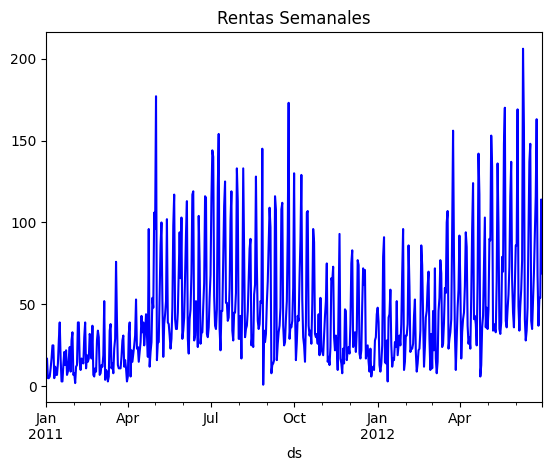

In [105]:
train['y'].plot(title='Rentas Semanales', style='-b')
plt.show()

In [106]:
train['y']

,y
ds,
2011-01-01,16.0
2011-01-02,17.0
2011-01-03,5.0
2011-01-04,5.0
2011-01-05,6.0
...,...
2012-06-26,37.0
2012-06-27,54.0
2012-06-28,54.0


In [107]:
history = train['y'].values.tolist()
predictions = list()

for i in range(len(test['y'])):
  yhat = history[-1]
  predictions.append(yhat)

  obs = test.iloc[i]['y']
  history.append(obs)
  # print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
mae = mean_absolute_error(test['y'], predictions)
print('Error - Modelo-Naive: RMSE: %.3f' % rmse)
print('MAE - Modelo-Naive: MAE: %.3f' % mae)


Error - Modelo-Naive: RMSE: 61.860
MAE - Modelo-Naive: MAE: 37.098


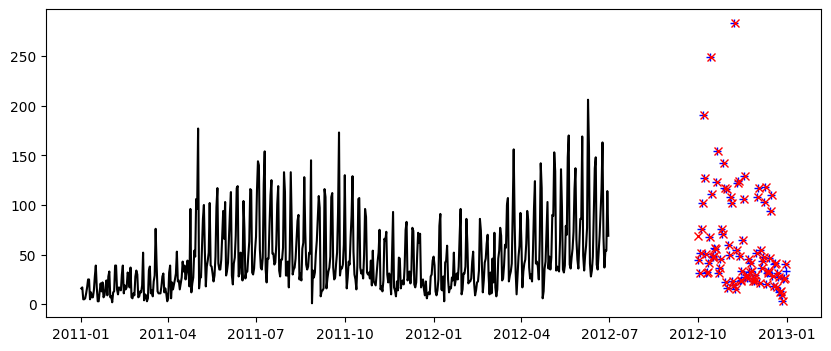

In [108]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '+b')
ax = plt.plot(test.index, predictions, 'xr')

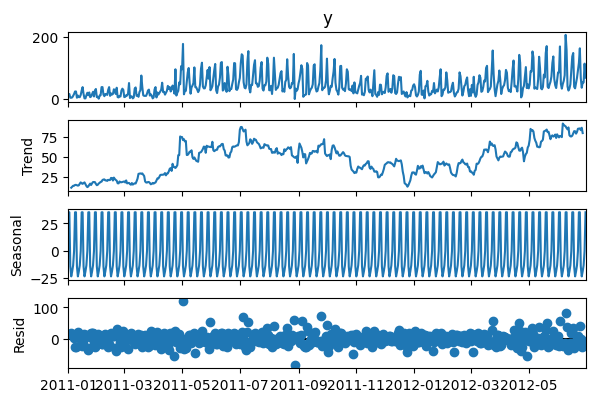

In [109]:
decomposition = seasonal_decompose(train['y'].resample('D').sum(), model='additive')
fig = decomposition.plot()
fig.set_size_inches(6,4)
plt.show()

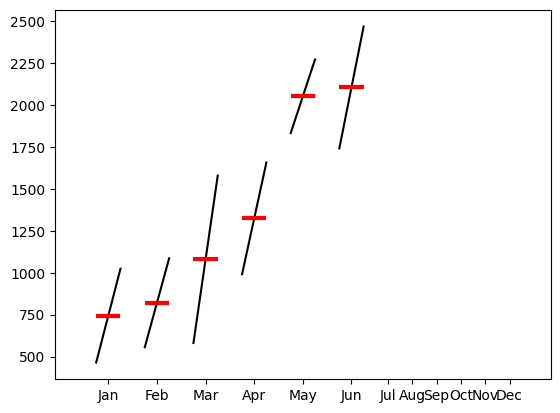

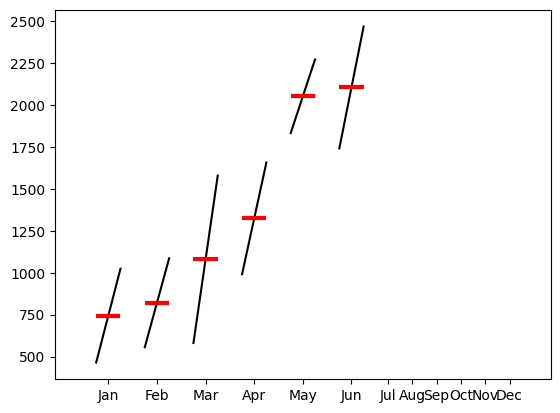

In [110]:
month_plot(train['y'].resample('ME').sum())

In [111]:
# validar multiples opciones
for order in [(1,1,1), (2,1,1), (1,1,2)]:
    for seasonal in [(1,1,1,7), (2,1,1,7)]:
        model = SARIMAX(train['y'], order=order, seasonal_order=seasonal)
        result = model.fit(disp=False)
        pred = result.get_forecast(steps=len(validation))
        mae = mean_absolute_error(validation, pred.predicted_mean)
        print(order, seasonal, mae)

(1, 1, 1) (1, 1, 1, 7) 22.360555802292296
(1, 1, 1) (2, 1, 1, 7) 22.383028670105258
(2, 1, 1) (1, 1, 1, 7) 22.40747628477699
(2, 1, 1) (2, 1, 1, 7) 22.426316648042217


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2) (1, 1, 1, 7) 22.399253496759233


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 1, 2) (2, 1, 1, 7) 22.418341200328676


SARIMAX Results:
MAE:  30.9405
RMSE: 47.1509


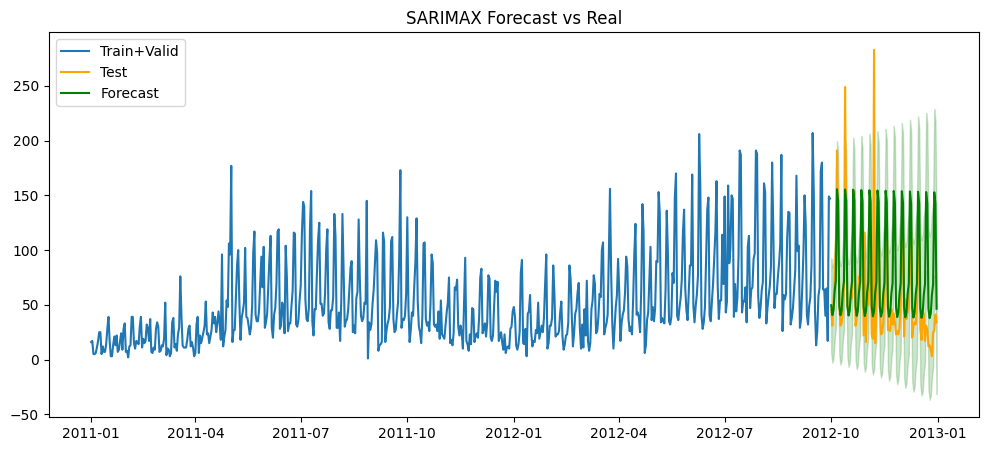

In [112]:
# SARIMA mejores parametros (hasta ahora)
order = (1, 1, 1)              # p, d, q
seasonal_order = (1, 1, 1, 7)  # P, D, Q, s

train_val = pd.concat([train, validation])
# Ajustar modelo
sarima_model = SARIMAX(
    train_val['y'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_result = sarima_model.fit(disp=False)


# Predicciones
sarima_forecast = sarima_result.get_forecast(steps=len(test))
pred = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# --- Métricas ---
mae = mean_absolute_error(test['y'], pred)
rmse = np.sqrt(mean_squared_error(test['y'], pred))

print("SARIMAX Results:")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.figure(figsize=(12,5))
plt.plot(train_val.index, train_val['y'], label='Train+Valid')
plt.plot(test.index, test['y'], label='Test', color='orange')
plt.plot(test.index, pred, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.2)
plt.title('SARIMAX Forecast vs Real')
plt.legend()
plt.show()